# Pre-processing

In [1]:
from graph_tool.all import *
import pickle

import numpy as np
import pandas as pd
import os
import sys

import collections
import csv

In [2]:
# Adri's path
os.chdir('/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/data/data_raw')
# Elsa's path
#os.chdir('/home/utilisateur/Desktop/Courses/Dynamics_on_networks/project/version_2/FinalProject/data/data_raw')

In [10]:
# Creating a test network

test_df = pd.DataFrame(columns = ['from', 'to', 't_second'])
test_df['from']= [1,1,3,2,1,2,4,4]
test_df['to']= [3,2,1,3,2,1,1,1]
test_df['t_second'] = [0, 2, 3, 5 ,6, 10, 1, 4]

## 1- UPLOADING DATA

### 1.1-twitter data 

In [11]:
df_edges_mentions= pd.read_pickle('./df_edges_mentions.pkl')
df_edges_retw= pd.read_pickle('./df_edges_retw.pkl')
df_edges_reply= pd.read_pickle('./df_edges_reply.pkl')

### 1.2-copenhagen data 

In [12]:
with open('sms_ijt.pickle', 'rb') as handle:
    sms_data = pickle.load(handle)

df_edges_sms = pd.DataFrame(sms_data, columns = ['from', 'to', 't_second'])

In [13]:
# study of the call with no reply

counter_no_reply = 0
counter_event = 0
data = []

import csv
with open('calls.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for line in list(spamreader)[1:]:
        counter_event+=1
        if int(line[0].split(',')[-1]) == -1 :
            counter_no_reply += 1
        else:
            L = np.asarray(line[0].split(',')).astype(int)[:-1]
            data.append([L[1],L[2],L[0]])
            
print('counter_no_reply',counter_no_reply)
print('counter_event',counter_event)
print('Proportion of calls with no reply',round(counter_no_reply/counter_event,3))

df_edges_calls = pd.DataFrame(data, columns = ['from', 'to', 't_second'])

counter_no_reply 366
counter_event 3600
Proportion of calls with no reply 0.102


### 1.3- College data set

In [14]:
data=[]
with open('CollegeMsg.txt', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for line in list(spamreader)[1:]:
        L = np.asarray(line).astype(int)
        data.append([L[0],L[1],L[2]])

df_edges_col_msg= pd.DataFrame(data, columns = ['from', 'to', 't_second'])


data=[]
with open('email-Eu-core-temporal.txt', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for line in list(spamreader)[1:]:
        L = np.asarray(line).astype(int)
        data.append([L[0],L[1],L[2]])

df_edges_col_email= pd.DataFrame(data, columns = ['from', 'to', 't_second'])

### 1.4- Add different columns according to aggregated time (second/minutes/hours/days)

In [15]:
def make_time_col(df_edges,t_sec_var):
    df_edges.loc[:,'t_minutes'] = df_edges.loc[:,t_sec_var].apply(lambda x: int(x/60))
    df_edges.loc[:,'t_hours'] = df_edges.loc[:,t_sec_var].apply(lambda x: int(x/3600))
    df_edges.loc[:,'t_days'] = df_edges.loc[:,t_sec_var].apply(lambda x: int(x/86400))
    
    for i_ in [1,2,5,10]:
        for unit_, unit_val_ in zip(['day', 'week', 'month'],[1, 7, 28,]):
            df_edges.loc[:,'t_{}{}'.format(i_,unit_)]= df_edges.loc[:,t_sec_var].apply(
                lambda x: round(x/(86400*i_*unit_val_)))

    return df_edges 


df_edges_mentions =make_time_col(df_edges_mentions,'t_second')
df_edges_retw =make_time_col(df_edges_retw,'t_second')
df_edges_reply =make_time_col(df_edges_reply,'t_second')

df_edges_sms =make_time_col(df_edges_sms,'t_second')
df_edges_calls =make_time_col(df_edges_calls,'t_second')

df_edges_col_msg =make_time_col(df_edges_col_msg,'t_second')
df_edges_col_email =make_time_col(df_edges_col_email,'t_second')

In [16]:
df_edges_test = make_time_col(test_df,'t_second')
df_edges_test.head(2)

,from,to,t_second,t_minutes,t_hours,t_days,t_1day,t_1week,t_1month,t_2day,t_2week,t_2month,t_5day,t_5week,t_5month,t_10day,t_10week,t_10month
0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# list of all data sets
list_datasets = [df_edges_calls,df_edges_sms,df_edges_mentions,df_edges_retw,df_edges_reply,df_edges_col_msg,
                 df_edges_col_email]

## 2- BUILING GRAPH

In [18]:
# FUNCTION WHICH CREATES THE AGGREGATED GRAPH: G IS UNDIRECTED AND G_D IS DIRECTED

def to_graph(df_edges,from_ ,to,sec,minutes, hours, days):
    
    # Edge list
    elist =np.array(df_edges)#
    #np.array(list(zip(df_edges[from_],df_edges[to],df_edges[sec],df_edges[minutes],df_edges[hours],df_edges[days])))

    # Building the UNdirected network
    g = Graph(directed=False)
    
    #ts_sec = g.new_ep("double")
    #ts_min = g.new_ep("double")
    #ts_h = g.new_ep("double")
    #ts_days = g.new_ep("double")
    vlabel = g.add_edge_list(elist, hashed=True)#, eprops=[ts_sec,ts_min,ts_h,ts_days])

    graph_tool.stats.remove_self_loops(g)  #removing self loops 
    graph_tool.stats.remove_parallel_edges(g) #and multiple edge
    
    #g.ep["ts_sec"] = ts_sec
    #g.ep["ts_min"] = ts_min
    #g.ep["ts_h"] = ts_h
    #g.ep["ts_days"] = ts_days
    #g.vp["label"] = vlabel
    
    ############- Directed 
    g_D = Graph(directed=True)
    
    ts_sec = g_D.new_ep("double")
    ts_min = g_D.new_ep("double")
    ts_h = g_D.new_ep("double")
    ts_days = g_D.new_ep("double")

    vlabel = g_D.add_edge_list(elist, hashed=True, eprops=[ts_sec,ts_min,ts_h,ts_days])
    
    graph_tool.stats.remove_self_loops(g_D)  #removing self loops 
    
    g_D.ep["ts_sec"] = ts_sec
    g_D.ep["ts_min"] = ts_min
    g_D.ep["ts_h"] = ts_h
    g_D.ep["ts_days"] = ts_days
    g_D.vp["label"] = vlabel

    return(g,g_D)

## 3 - SAVING NETWORKS

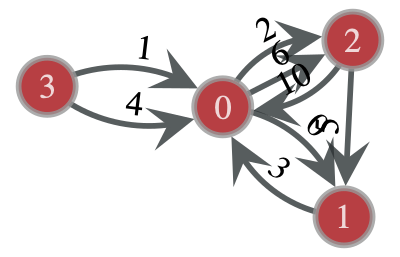

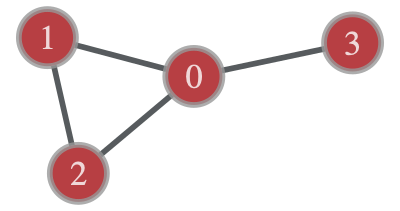

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f881aeb5970, at 0x7f881b556c70>

In [19]:
#test
g_test,g_D_test = to_graph(df_edges_test,'from','to','t_second','t_minutes','t_hours','t_days')

# Plot 
graph_draw(g_D_test, vertex_text= g_D_test.vertex_index, edge_text= g_D_test.ep.ts_sec, output_size = (200, 200))
# Plot 
graph_draw(g_test, vertex_text= g_test.vertex_index,  output_size = (200, 200))

In [20]:
#dict(g_D_test.edge_properties).keys()

In [21]:
# sociopatterns
g_calls,g_D_calls = to_graph(df_edges_calls,'from','to','t_second','t_minutes','t_hours','t_days')
g_sms,g_D_sms = to_graph(df_edges_sms,'from','to','t_second','t_minutes','t_hours','t_days')

# college
g_col_msg, g_D_col_msg = to_graph(df_edges_col_msg,'from','to','t_second','t_minutes','t_hours','t_days')
g_col_email, g_D_col_email = to_graph(df_edges_col_email,'from','to','t_second','t_minutes','t_hours','t_days')


# tweeter networks
g_men,g_D_men = to_graph(df_edges_mentions,'from_id','to_id','t_second','t_minutes','t_hours','t_days')
g_rt,g_D_rt = to_graph(df_edges_retw,'from_id','to_id','t_second','t_minutes','t_hours','t_days')
g_re,g_D_re = to_graph(df_edges_reply,'from_id','to_id','t_second','t_minutes','t_hours','t_days')

In [28]:
#dict(g_D_men.edge_properties).keys()

In [22]:
# ADRI
os.chdir('/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/data/graphs_raw')

# ELSA 
#os.chdir('/home/utilisateur/Desktop/Courses/Dynamics_on_networks/project/version_2/FinalProject/data/graphs_raw')

In [25]:
names = ['calls', 'sms', 'mentions','retweets', 'reply','msg','email']
G_D =   [g_D_calls, g_D_sms ,g_D_men,  g_D_rt, g_D_re,g_D_col_msg,g_D_col_email]
G =     [g_calls,  g_sms , g_men, g_rt, g_re,g_col_msg,g_col_email]

for i in range(len(names)):
    name = names[i]
    print('saving '+name)
    
    g_D = G_D[i]
    g_D.save('./'+name+"_g_d.xml.gz")
    
    g = G[i]
    g.save('./'+name+"_g.xml.gz")

saving calls
saving sms
saving mentions
saving retweets
saving reply
saving msg
saving email
